
<br>
-------------------------------------------------------------------------------<br>
Name:        V3<br>
Purpose:     P-Control with prediction<br>
Author:      Christian Buchholz, Marcus Vogt<br>
Created:     01.12.2021<br>
Copyright:   Chair of Sustainable Manufacturing and Life Cycle Engineering, Institute of Machine Tools and Production Technology, Technische UniversitÃ¤t Braunschweig, Langer Kamp 19b, 38106 Braunschweig, Germany<br>
Licence:     MIT (see License)<br>
-------------------------------------------------------------------------------<br>


In [1]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import helpers.WetAirToolBox as WetAirToolBox
import helpers.dataPreprocessing as dataPreprocessing
from V2 import P_controller
import V3

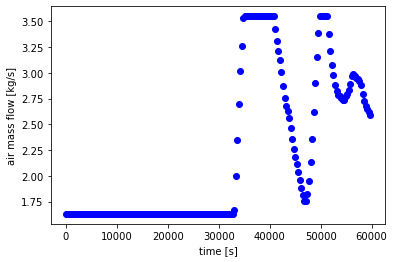

In [2]:
dataPath = os.path.join(os.getcwd(), "data")
data = pd.read_excel(os.path.join(dataPath, "t_step300_kp-30000_Tf4000_u_massflow.xlsx"), engine='openpyxl')
moisture_load = pd.read_csv(os.path.join(dataPath, "moisture_load.csv"))

T_TP_room_set = -60 # Dew point temperature of the supply air entering the room [°C]
P = -100000 # Slope of the proportional controller
t_step_controller = 300 # length of a time steps between two calculations of the manipulated variable [sec]
t_step_Measurements_BLB = 60 # length of a time steps between two measurements of the state variables [sec]
N = 7 # ength of the prediction horizon as number of time steps
u_min = 1.63 # minimum value of manipulated variable / mass flow [kg/s]
u_max = 3.55 # maximum value of manipulated variable / mass flow [kg/s]
T_room_0 = 20 # initial value of temperatur in the room [°C]
T_TP_room_0 = -50 # initial value of dew point temperatur in the room [°C]
X_room_0 = WetAirToolBox.humidity_dewpoint2abs(T_room_0, T_TP_room_0) # initial value of humidity in the room [kg water / kg air]
beta_CO2_room_0 = 350 # initial value of CO2-concentration in the room [ppm]

CO2_in = data.beta_CO2_in
CO2_in_prediction = dataPreprocessing.rescale_data(CO2_in, int((t_step_Measurements_BLB / t_step_controller) * len(CO2_in)))

m_X_delta = moisture_load.moisture_load
m_X_delta_prediction = dataPreprocessing.rescale_data(m_X_delta, int((t_step_Measurements_BLB / t_step_controller) * len(m_X_delta)))

TemperatureIn_prediction = np.ones(1432)*20
DewPointIn_set_prediction = np.ones(1432)*(-60)

# This part is for testing the code. The control variable curve shown is based on sample curves of the state variables and there is no closed control loop.
Range = 200
t = np.arange(0, Range*t_step_controller, t_step_controller)
fig, ax = plt.subplots()
for i in range(Range):
    if i == 0:
        x0 = np.array([T_room_0, X_room_0, beta_CO2_room_0]).reshape(-1, 1)
        u0 = V3.predictive_p_controller(i, u_min, u_max, x0, T_TP_room_set, N, t_step_controller, P, TemperatureIn_prediction, DewPointIn_set_prediction, m_X_delta_prediction, CO2_in_prediction)
        ax.scatter(t[i], u0, color='blue')
    else:
        x0 = np.array([data.T_room[i], data.X_room[i], data.beta_CO2_room[i]]).reshape(-1, 1)
        u0 = V3.predictive_p_controller(i, u_min, u_max, x0, T_TP_room_set, N, t_step_controller, P, TemperatureIn_prediction, DewPointIn_set_prediction, m_X_delta_prediction, CO2_in_prediction)
        ax.scatter(t[i], u0, color='blue')

ax.set_xlabel('time [s]')
ax.set_ylabel('air mass flow [kg/s]')
plt.show()

